# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create-dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data-dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative-dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient-data-fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler-results-fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs-dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models-dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model-type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use-redshift-features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits-per-majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target-label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n-folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num-epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n-parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random-seed}$: For reproducibility.

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [3]:
from snapi.query_agents import TNSQueryAgent
tns_agent = TNSQueryAgent()
tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
all_names = [x for x in all_names if int(x[:4]) > 2018] # because pre-2019 templates are pretty bad
print(len(all_names), all_names[:5])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:29 --:--:--     0curl: (6) Could not resolve host: www.wis-tns.org


BadZipFile: File is not a zip file

The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

For the entire TNS dataset (~16000 events), this takes ~30 minutes on 8 parallel cores.

In [2]:
from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents
import_all_names(
    all_names, save_dir,
    checkpoint_freq=1024,
    n_cores=9,
    overwrite=True
) # set overwrite=False to continue from where left off

14897 names to query across 9 cores.
Processing 1065 transients in batch


/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/s

-18.41447555434775
-15.604534463932573
-18.54288540346315
-19.20531388876157
-19.255339987813514
-18.830261267107087
-19.123606973730542
-19.22627918923987
-15.801296129568827
-19.056752274000832
-18.96057154957214
-19.875989578016686
-19.79155561904516
-20.28364350632856
-19.018678213569864
-18.99150586208819
-19.055609119856197
-17.65320045765217
-20.847894187891082
nan
-19.0171046714902
-18.230483688491375
-13.081239102700508
-19.74195395586404
-19.171416361718187
-18.372845777595547
-19.666239609349354
-19.23854839046524
-16.649755432473444
-18.49073932997437
-18.781957648410987
-18.790548324470045
nan
-16.480119699744805
-18.98309995339803
-19.759346546139952
-16.245369059111102
-16.82440198909899
-19.126521929561253
-16.240727505130046
-19.60403490817878
-19.51479907880557
-19.61499979936706
-16.700471922715998
-19.451213636189394
-16.45593306706585
-17.841239554902288
-18.523101855396906
-20.325606846090054
-19.998924605549465
-19.629223297420324
-19.29156860954679
-18.999324299

-17.203439940190485
-17.23436483284182
-19.008466339388526
-19.05585948499371
-16.620110469867754
-18.96755350023646


-18.391562529447437
-18.93466041874674
-19.11999972143335
-18.351145420568724
-16.99116687113086
-19.398399364418985
-9.106007931896798
-18.844672254200134
-19.61295419858909
-18.81775426613356
nan
-19.559569994610946
-19.23533547604669
-18.099667876827088
-19.256598194909767
-18.659766133112075
-19.578696572235177
-19.284850561220754
-17.129215969362363
-16.531337150043775
-17.62014485436572
-19.923949015137442
-17.146717018610495
-16.61651258458276
-19.67339929385411
-19.069985419425077
-18.588997376511593
-19.445621912302045
-19.664997480390234
-19.01503477914567
-18.880274751012674
-18.77241838696838
-18.574529186766522
-18.088766989932672
-19.287725229963698
-18.560573561915835
-17.60551456841048
-19.23078764578481
-19.758381728165002
-18.22082056918368
-19.386308412597195
-19.320238930315256
-21.920800983370643
-19.5624043412008
-19.27788869417113
-19.62245191749468
-19.661081056736194
-18.87077916747769
-18.49140190978942
-17.021798713004085
-18.53621855426491
-18.78602713874065

-18.710718868115062
-19.083634787928442
-22.543021706114704
-19.19895464984056
-18.555662043480464
-19.573389832063217
-18.311797750014982
-18.03510021153405
-19.28526582612838
-18.8812832689186
-22.249767036136454
-19.68816791634579
-19.648888891676062
-18.754531149104288
-20.118654178806217
-19.251090742801576
nan
-19.19331658195298
-19.06558853236869
-19.39234391153257
-16.368318853535833
-21.701038877960638
-17.871372347166215
-17.47819560857597
-19.1597970539297
-18.809022872669495
-17.34018636161202
-16.811030286521664
-19.692139178492
-17.043834527482897
-19.376288608672922
-17.688125850312176
-17.41129533936144
-18.871038170839636
-19.328295598995954
-18.27561230149954
-17.88687627391674
-19.442763156829827
-17.526529034655475
-18.870046058230184
-17.707114050983183
-18.177414495736414
-15.778517325623847
-19.15298746551592
-17.47484049261482
-17.020318619640104
-19.428139682870665
-19.590257547687862
-17.908886530388223
-18.67252213264652
-17.703445274926292
-18.82019537526933

-16.564379465781826
-19.47457329966766
-16.421893677829264
-19.505193177026978
-18.516006908701367
-19.051559656732895
-17.043035327504438
-16.700258313437867
-17.751882449278437
-18.2243441051189
-20.757434455577158
-19.743975409150874
-19.059688535177894
-19.17015783038526
-18.145400390068524
-18.45435443471392
-19.33987290996295
-19.447719147457313
-19.4254198644663
-18.333545583531382
-19.180705953327312
-18.310717401063073
-17.84248371215039
-18.90467438785447
-17.325382915334004
-19.995455859270386
-19.535366923986185
inf
-18.8447371142631
-19.073463120199953
-16.858749278382675
-19.37414707206312
-18.475772390626013
-18.77349359502375
-19.471532813223224
-17.42926152709896
-17.884844642425737
-19.67800469042393
-16.587643023774767
-21.210391818877017
-19.481567095632638
-18.662094498185454
-18.624098025989486
-19.67711560096865
-19.419434800183968
-18.83598355222189
-18.27098505041633
-20.0261928355618
-18.236526890716725
-21.38990119136796
-19.12923048382618
-18.855631414869077

-21.113896624448188
-16.282647709208707
-18.668078119479592
-19.612311054957686
-19.740909674689984
-18.607380250285175
-18.38905353061002
-18.371401822742936
-19.28177287102697
-19.31672909494804
-18.611462884655744
-19.60260847116285
-19.254155506315573
-19.61018146001728
-19.22479726917028
-17.160697380280933
-19.237954873687027
-18.52388692562855
-18.515043138782907
-18.953866515377854
-17.08099837821081
-19.69815041368728
-18.72873904462408
-19.514778337861628
-19.081325375746207
-18.608625219333142
-19.636382027346713
-19.481340222206153
-17.11524960123806
-22.270646377660782
-17.012287206885112
-19.541816649018482
-17.024896762503094
-16.313772046452183
-19.045247841503013
-19.065995526635984
-19.043633658849533
-18.835559451153493
-19.350249574244
-19.573065920865375
-20.217247819382393
-18.59709412645637
-17.939091347538216
-18.065041054044052
-17.624010085780924
-16.931062817667474
-19.230110405098966
-19.779761558560946
-20.29325871726016
-19.107267193832772
-19.032132327709

-19.111624216089194
-19.126699222551707
-16.455930862629714
-19.40959280601647
-18.0436925297875
-19.18290556580164
-19.96818339959538
-18.095154081458897
-18.010367279013256
-17.156530964633394
-19.363463937031575
-19.349247484659298
-18.95543160002867
-19.523568915035668
-19.74471092108831
-19.509384295217643
-17.934813739929563
-19.47756553192016
-16.979410640056045
-19.429182111047023
nan
-19.57843555270337
-19.499266326586987
-19.133684684603843
-19.485976500626585
-19.11574616581606
-17.62164631494156
-19.526197992591705
-17.982828552405632
-18.993938589169645
-18.845747023379012
-19.99045538974202
-19.427494210539514
-19.432910017750142
-17.744354310111376
-18.80071178731345
-18.354796318334063
-19.21629343312625
-19.27278025324476
-16.904908427103734
-18.443182364422043
-19.056343601624818
-19.094168783695988
-19.630097050328754
-17.36415192173894
-17.743189278409876
-18.933126618660186
-19.227396957822652
-17.956374324729342
-18.941620240052067
-21.584558452778136
-19.32285855

-19.41989264955718
-19.353804236260338
-19.060740226555726
-13.944735943829109
-19.1219272183928
-19.16130115243737
-18.400902733035938
-18.66211771193743
-16.735806287462836
-15.514153904140327
-20.594402169692263
-19.171201843390094
-18.98136555710001
-19.111017211642462
-18.761968642443144
-21.843532646806192
-19.32557202306892
-19.114265344343778
-19.40838842644203
-19.532248960878203
-17.383917592144662
-19.722888864521398
-19.46111700748048
-19.28871646221561
-16.75065883531248
-19.619076624173946
-17.941776102653648
-20.275800805146496
-19.242526818727065
-19.63143773424321
-21.536282439168616
-18.822726101144347
-19.10247020060171
-19.502598099807614
-17.482931404472325
-19.126746778031954
-19.734073674852056
-19.317122861387393
-19.123660699305557
-19.456029206255955
-19.709263175513513
-19.432764402497536
-17.92789454929113
-19.416715439199148
-19.103839301949932
-19.233526043780238
-18.914561947870908
-18.52974961763618
-19.147454501650476
-16.899121029634227
-20.58099370051

-18.31304011407029
-18.22635965412587
-18.352483986345433
-18.884247381728475
-14.118543591753662
-19.11564015348188
-19.04896816768308
-16.197055953829178
-19.606710797482982
-18.967720962320914
-17.99693611988428
-16.362882911077495
-19.06386586022211
-19.62074588984735
-19.867988631253127
-18.74980136586379
-20.466119900683612
-19.378124999516004
-19.74789744177679
-19.292233392791037
-19.42152953624292
-18.64506656898088
-19.334537417021576
-18.89728690260994
-19.000775537998578
-19.138898229092298
-18.469656775429346
-21.3658264425053
-19.598215797153543
-20.356884481927498
-15.497558506186047
-19.438630940717278
-19.552444437132362
-19.53580674337463
-19.076485406995598
-19.644906744186684
-19.52830194175291
-18.81907221079886
-18.934642533415587
-18.642080843817183
-17.63056803597674
-18.946507495775943
-16.81731648503607
-18.522282976927684
-19.442850008350266
-18.9370566347803
-19.186182145278927
-19.900879861974477
-18.178875665167812
-19.480602596114974
-18.843173338411642
-

-17.9603101272354
-17.708777221562915
-19.124426824217885
-16.52637003274243
-19.281052850168102
-19.637413387692668
-17.54736464824388
-19.47475959983885
-19.440320216380552
-19.22953320847174
-19.21104765619811
-18.26227630474361
-19.438395271519568
-19.802503498030475
-18.409839818008685
-19.529663661675638
-19.077761353769514
-19.067325868961255
-18.88026338702748
-19.443148571855414
-19.154012272503774
-18.969505351604795
-19.361780020408414
-17.475234665317938
-19.577112567881063
-19.30735882127856
-16.75417205697
-19.29764068953129
-19.638628626069806
-19.46006373691122
-16.523199674848584
-19.29029424798107
-18.974065582024362
-21.417287042326432
-17.205224968196518
-17.729711973469623
-19.733263248143746
Finished processing, making transient group now
Total transients saved: 6305.
Processing 1064 transients in batch
-19.476883244423846
-19.068318710078223
-19.501643902175513
-17.505882424442042
-19.503817767138813
-18.444191739556924
-17.250087550518177
-18.55695227925968
-18.

-19.000648201630284
-18.632336483095465
-19.359215313306255
-14.62470204894633
-19.711281668393152
-18.808263210180574
-17.3124397093832
-22.183377773864247
-18.755103685176028
-19.726173089443893
-20.020373831351524
-20.809034591904556
-19.41545924438276
-18.995704421172483
-19.398544259912246
-20.676574417770144
-19.48738300429611
-19.22383218002718
-19.164205260167847
-19.545602963236473
-16.153376980330947
-19.02912590450286
-18.324785215073984
-19.84354795941169
-19.295544052445806
-20.307050739875166
-19.574359109531212
-19.28325485431916
-18.731159150416303
-19.623397405990573
-15.14904139685495
-19.54275273467453
-19.065513977683924
-16.280847107784435
-19.397747655337902
-15.742841232416987
-20.261722260455905
-18.64973662841727
-19.385500469641713
-19.58077930127416
-19.24523679648044
-18.914055862127302
-19.49919031252022
-19.410071002825838
-17.081195326921808
nan
-18.781701090499908
-17.092134406032795
-18.495195681767136
-19.699018387988097
-20.54254285866498
-19.01827777

-19.184904537344874
-18.958184682928835
-18.033653253232252
-19.379690164820257
-19.70416943043316
-18.557886671961818
-19.508780317351693
-17.112122679566383
-17.567797304643356
-17.68536898868379
-19.57480837560023
-18.887908305820854
-19.178387797658694
-19.37729648160509
-19.06687099696157
-18.928066065631032
-19.097193804101792
-19.246381637883292
-18.391150355471034
-19.23319278181752
-17.90094861077957
-19.46369741711044
-16.898860211165367
-20.7687520654873
-19.516476416727613
-18.80429180766786
-18.82300245488366
-17.34190876779405
-18.387574804061426
-19.468514135121893
-19.683377762743756
-19.285500822196394
-19.39286187602769
-18.09393963874927
-19.322330583180204
-19.588294866543006
-19.48355906402159
-18.43083488484712
-18.983061540490247
-19.43931101027768
-19.606117984582134
-20.080825639284168
-19.149658431569396
-19.15707858621497
-19.04319865254121
-19.595257189970955
-19.105681413555565
-18.99530871164445
-17.363340112097113
-18.77316357386643
-19.098485937853408
-2

In [5]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
transient_group.add_col('peak_abs_mag', lambda x: x.peak_abs_mag)
print(len(transient_group.metadata))
print(transient_group.metadata.head())
print(transient_group.metadata.groupby('spec_class').count())

7420
                  ra        dec                     internal_names spec_class  \
id                                                                              
2019J     150.944878   6.773457  PS18crs, ZTF19aacxrab, ATLAS19cay     SLSN-I   
2019aafe  349.068683  48.428444                       ZTF19abzfxel     SN IIn   
2019aamp  219.455292  20.304611                       ZTF19aantokv     SLSN-I   
2019aanx  112.499958  13.095333                       ZTF19ackiwff    SLSN-II   
2019aaot    3.069526  -5.727405                       ZTF19aazdroc        AGN   

          redshift  peak_abs_mag  
id                                
2019J        0.120    -20.000008  
2019aafe     0.074    -19.073458  
2019aamp     0.404    -22.218369  
2019aanx     0.403    -22.112486  
2019aaot     0.283    -22.470427  
                     ra   dec  internal_names  redshift  peak_abs_mag
spec_class                                                           
AGN                  40    40             

## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

For all 7202 TNS transients passing quality cuts, this takes ~30 minutes.

In [6]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import SuperphotPrior
from superphot_plus.config import SuperphotConfig
import os

config = SuperphotConfig.from_file("config.yaml")
priors = SuperphotPrior.load('priors/global_priors_hier_svi')

svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 512,
    pad=True,
    overwrite=True # set to False to continue where left off
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

2025-02-28 12:53:25,701 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 12:53:25,708 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 12:53:25,708 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740765205.709019 20759290 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740765205.801659 20759290 service.cc:145] XLA service

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740765252.172549 20863129 service.cc:145] XLA service 0x33b055160 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740765252.172679 20863129 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740765252.178455 20863129 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740765252.178477 20863129 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
I0000 00:00:1740765252.179749 20863127 service.cc:145] XLA service 0x31e8e64e0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740765252.179781 20863127 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740765252.189566 20863127 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740765252.189587 20863127 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
I0000 00:00:1740765252

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 12:55:10,117 - MainProcess - Worker done
2025-02-28 12:55:12,022 - MainProcess - Worker done
2025-02-28 12:55:12,091 - MainProcess - Worker done
2025-02-28 12:55:12,222 - MainProcess - Worker done
2025-02-28 12:55:13,253 - MainProcess - Worker done
2025-02-28 12:55:14,160 - MainProcess - Worker done
2025-02-28 12:55:14,168 - MainProcess - Worker done
2025-02-28 12:55:16,984 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0


Finished checkpoint 1 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 12:56:30,183 - MainProcess - Worker done
2025-02-28 12:56:31,784 - MainProcess - Worker done
2025-02-28 12:56:33,309 - MainProcess - Worker done
2025-02-28 12:56:35,724 - MainProcess - Worker done
2025-02-28 12:56:37,232 - MainProcess - Worker done
2025-02-28 12:56:37,777 - MainProcess - Worker done
2025-02-28 12:56:37,883 - MainProcess - Worker done
2025-02-28 12:56:38,254 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 2 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Metal device set to: Apple M1 Pro
Apple M1 Pro

systemMemory: 16.00 GB

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 12:57:53,041 - MainProcess - Worker done
2025-02-28 12:57:54,932 - MainProcess - Worker done
2025-02-28 12:57:55,231 - MainProcess - Worker done
2025-02-28 12:57:56,324 - MainProcess - Worker done
2025-02-28 12:57:57,335 - MainProcess - Worker done
2025-02-28 12:57:57,671 - MainProcess - Worker done
2025-02-28 12:57:57,750 - MainProcess - Worker done
2025-02-28 12:57:58,186 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down


Finished checkpoint 3 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 12:59:11,866 - MainProcess - Worker done
2025-02-28 12:59:15,429 - MainProcess - Worker done
2025-02-28 12:59:16,066 - MainProcess - Worker done
2025-02-28 12:59:16,950 - MainProcess - Worker done
2025-02-28 12:59:17,537 - MainProcess - Worker done
2025-02-28 12:59:17,839 - MainProcess - Worker done
2025-02-28 12:59:19,339 - MainProcess - Worker done
2025-02-28 12:59:19,629 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 4 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
Metal device set to: Metal device set to: Apple M1 Pro
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:00:36,741 - MainProcess - Worker done
2025-02-28 13:00:41,488 - MainProcess - Worker done
2025-02-28 13:00:41,903 - MainProcess - Worker done
2025-02-28 13:00:42,750 - MainProcess - Worker done
2025-02-28 13:00:42,773 - MainProcess - Worker done
2025-02-28 13:00:45,099 - MainProcess - Worker done
2025-02-28 13:00:46,197 - MainProcess - Worker done
2025-02-28 13:00:48,413 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 5 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro
Metal device set to: Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:02:08,895 - MainProcess - Worker done
2025-02-28 13:02:09,233 - MainProcess - Worker done
2025-02-28 13:02:09,690 - MainProcess - Worker done
2025-02-28 13:02:10,930 - MainProcess - Worker done
2025-02-28 13:02:11,409 - MainProcess - Worker done
2025-02-28 13:02:12,014 - MainProcess - Worker done
2025-02-28 13:02:12,738 - MainProcess - Worker done
2025-02-28 13:02:13,018 - MainProcess - Worker done
[INFO/MainProcess] process shutting down


Finished checkpoint 6 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:03:30,820 - MainProcess - Worker done
2025-02-28 13:03:34,069 - MainProcess - Worker done
2025-02-28 13:03:34,680 - MainProcess - Worker done
2025-02-28 13:03:35,004 - MainProcess - Worker done
2025-02-28 13:03:36,259 - MainProcess - Worker done
2025-02-28 13:03:36,286 - MainProcess - Worker done
2025-02-28 13:03:36,938 - MainProcess - Worker done
2025-02-28 13:03:37,043 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 7 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:04:55,310 - MainProcess - Worker done
2025-02-28 13:04:55,511 - MainProcess - Worker done
2025-02-28 13:04:57,190 - MainProcess - Worker done
2025-02-28 13:04:59,518 - MainProcess - Worker done
2025-02-28 13:04:59,576 - MainProcess - Worker done
2025-02-28 13:04:59,812 - MainProcess - Worker done
2025-02-28 13:05:00,640 - MainProcess - Worker done
2025-02-28 13:05:02,090 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down


Finished checkpoint 8 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740765926.263926 20893526 service.cc:145] XLA service 0x33a5bf590 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740765926.263952 20893526 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740765926.274326 20893526 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740765926.274351 20893526 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
2025-02-28 13:06:27,013 - MainProcess - Worker done
2025-02-28 13:06:27,610 - MainProcess - Worker done
2025-02-28 13:06:28,646 - MainProcess - Worker done
2025-02-28 13:06:29,676 - MainProcess - Worker done
2025-02-28 13:06:30,040 - MainProcess - Worker done
2025-02-28 13:06:32,010 - MainProcess - Worker done
2025-02-28 13:06:32,027 - MainProcess - Worker done
2025-02-28 13:06:37,596 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainPro

Finished checkpoint 9 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro
systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:07:07,778 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:07:07,780 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:07:07,780 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766027.780502 20898048 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740766027.855839 20898048 service.cc:145] XLA service

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:08:17,802 - MainProcess - Worker done
2025-02-28 13:08:18,074 - MainProcess - Worker done
2025-02-28 13:08:22,462 - MainProcess - Worker done
2025-02-28 13:08:22,542 - MainProcess - Worker done
2025-02-28 13:08:22,921 - MainProcess - Worker done
2025-02-28 13:08:24,474 - MainProcess - Worker done
2025-02-28 13:08:26,500 - MainProcess - Worker done
2025-02-28 13:08:27,318 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0


Finished checkpoint 10 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:08:55,664 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:08:55,673 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:08:55,674 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766135.674086 20903092 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2025-02-28 13:08:55,706 - MainProcess - Unable to initialize backe

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:08:55,938 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:08:55,939 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:08:55,939 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766135.939297 20903088 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740766136.064956 20903088 service.cc:145] XLA service

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:10:00,387 - MainProcess - Worker done
2025-02-28 13:10:01,964 - MainProcess - Worker done
2025-02-28 13:10:03,684 - MainProcess - Worker done
2025-02-28 13:10:04,757 - MainProcess - Worker done
2025-02-28 13:10:05,537 - MainProcess - Worker done
2025-02-28 13:10:06,429 - MainProcess - Worker done
2025-02-28 13:10:08,273 - MainProcess - Worker done
2025-02-28 13:10:09,357 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down


Finished checkpoint 11 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740766239.777045 20907863 service.cc:145] XLA service 0x321fc0120 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740766239.777132 20907863 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
2025-02-28 13:10:39,780 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:10:39,788 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:10:39,789 - MainProcess - Platform 'METAL' is experimental and not all 

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740766240.044218 20907851 service.cc:145] XLA service 0x33be6f810 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740766240.044236 20907851 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740766240.044747 20907848 service.cc:145] XLA service 0x17de1f080 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740766240.044758 20907848 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740766240.048413 20907851 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740766240.048893 20907851 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
I0000 00:00:1740766240.050476 20907848 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740766240.050491 20907848 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
2025-02-28 13:10:40,35

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:11:44,262 - MainProcess - Worker done
2025-02-28 13:11:45,159 - MainProcess - Worker done
2025-02-28 13:11:46,384 - MainProcess - Worker done
2025-02-28 13:11:46,758 - MainProcess - Worker done
2025-02-28 13:11:47,055 - MainProcess - Worker done
2025-02-28 13:11:50,454 - MainProcess - Worker done
2025-02-28 13:11:51,084 - MainProcess - Worker done
2025-02-28 13:11:53,016 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 12 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:13:32,224 - MainProcess - Worker done
2025-02-28 13:13:33,246 - MainProcess - Worker done
2025-02-28 13:13:33,636 - MainProcess - Worker done
2025-02-28 13:13:34,994 - MainProcess - Worker done
2025-02-28 13:13:35,476 - MainProcess - Worker done
2025-02-28 13:13:35,578 - MainProcess - Worker done
2025-02-28 13:13:38,812 - MainProcess - Worker done
2025-02-28 13:13:39,752 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down


Finished checkpoint 13 of 14


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependenc

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:14:14,376 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:14:14,378 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:14:14,378 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766454.378177 20917819 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2025-02-28 13:14:14,438 - MainProcess - Unable to initialize backe

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:14:14,896 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:14:14,911 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:14:14,911 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766454.912045 20917808 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2025-02-28 13:14:14,974 - MainProcess - Unable to initialize backe

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-28 13:14:15,179 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 13:14:15,183 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 13:14:15,183 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740766455.183551 20917811 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
2025-02-28 13:14:15,344 - MainProcess - Unable to initialize backe

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740766455.394090 20917826 service.cc:145] XLA service 0x3253b00f0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740766455.394164 20917826 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740766455.396860 20917826 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740766455.396877 20917826 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
2025-02-28 13:15:20,871 - MainProcess - Worker done
2025-02-28 13:15:21,488 - MainProcess - Worker done
2025-02-28 13:15:21,732 - MainProcess - Worker done
2025-02-28 13:15:23,441 - MainProcess - Worker done
2025-02-28 13:15:24,533 - MainProcess - Worker done
2025-02-28 13:15:25,107 - MainProcess - Worker done
2025-02-28 13:15:26,754 - MainProcess - Worker done
2025-02-28 13:15:32,047 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[IN

Finished checkpoint 14 of 14


['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']


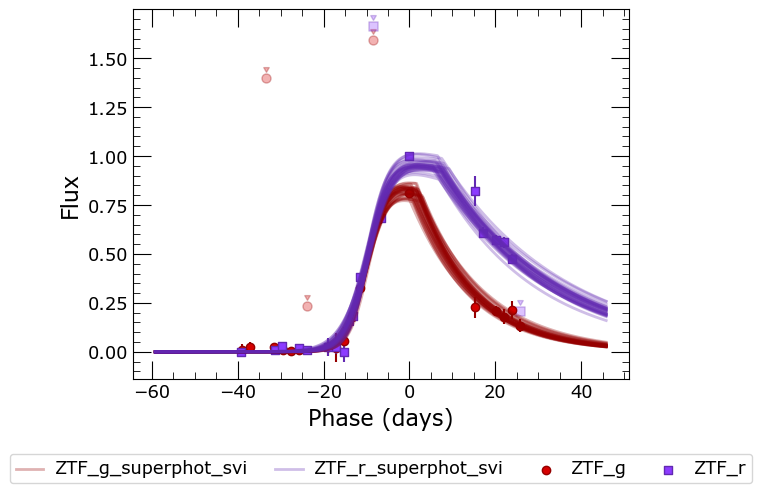

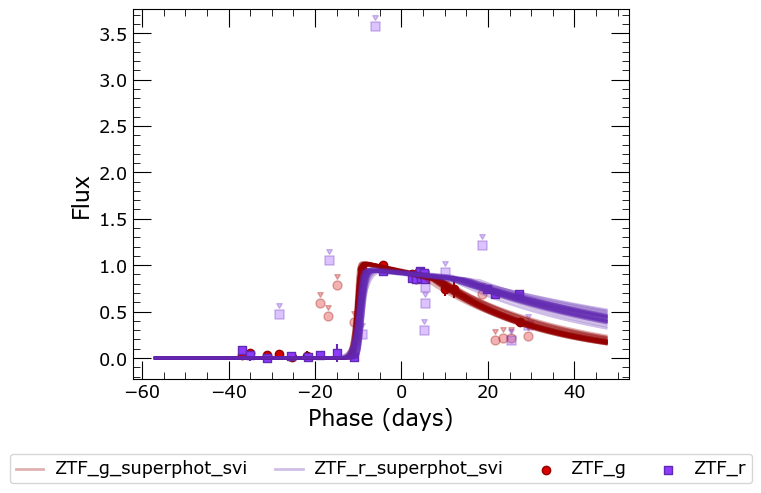

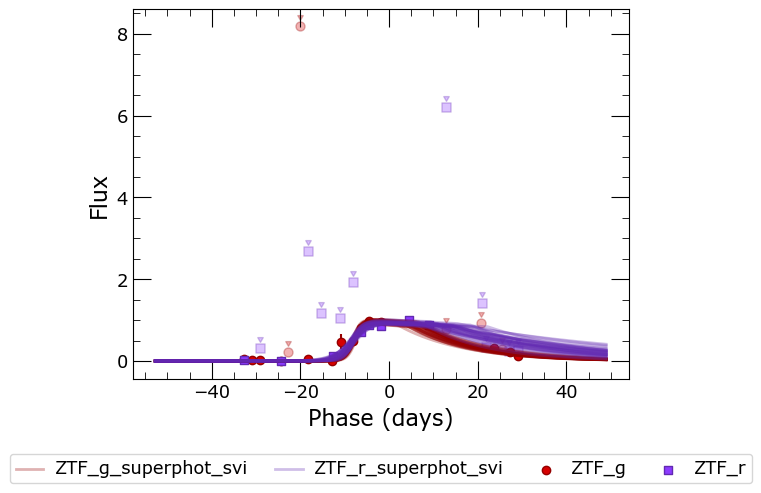

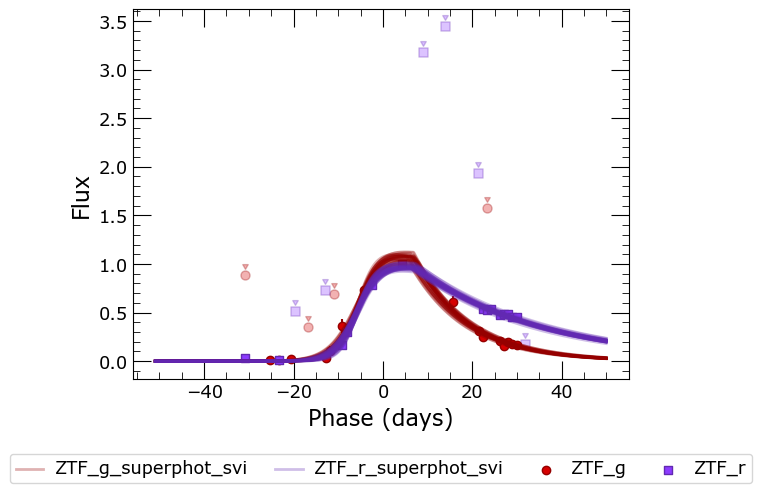

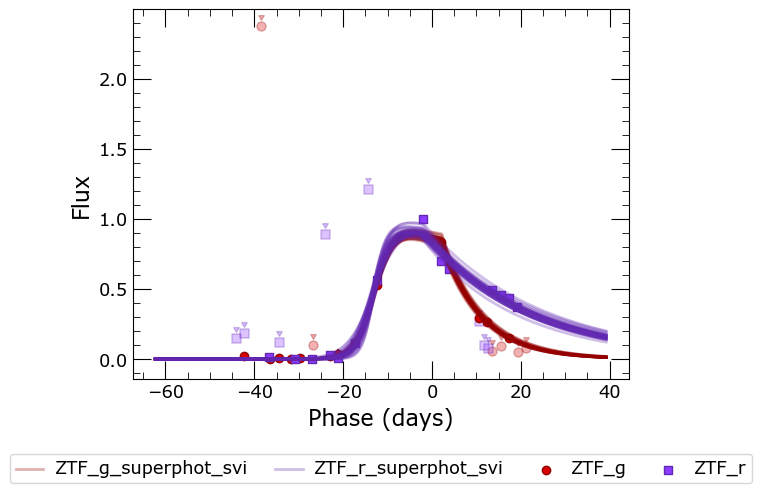

In [7]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]:
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2a: Hierarchical Bayesian Inference (slowest)
Optimize priors hierarchically for the dataset. Uses subset (~500) of objects.

In [1]:
from snapi.scripts import fit_many_hierarchical
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

import warnings
warnings.filterwarnings("ignore")

config = SuperphotConfig.from_file("config.yaml")
priors = generate_priors(
    ["ZTF_r", "ZTF_g"],
    priors_dir='priors',
)

transient_group = TransientGroup.load(config.transient_data_fn)
print(len(transient_group))
print("Transient group loaded")

svi_sampler = SVISampler(
    priors=priors,
    num_events=500,
    num_iter=20_000,
    step_size=0.01,
    random_state=42,
    max_length=100,
)

global_priors, indiv_results = fit_many_hierarchical(
    transient_group,
    500,
    svi_sampler,
    pad=False
)
global_priors[0].save("hierarchical_svi_global_loc")
global_priors[1].save("hierarchical_svi_global_scale")
srg_indiv = SamplerResultGroup(indiv_results)
srg_indiv.save("hierarchical_svi_srg")

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
2025-02-28 08:29:30,090 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-28 08:29:30,093 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-28 08:29:30,093 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly 

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

6817
Transient group loaded
['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
129
Starting hierarchical fit
Global beta/gamma mu: [  0.01   1.   -10.     0.  ]
Global gamma1 sigma: [1.e-02 1.e+00 3.e+01 1.e+00]
Global beta/gamma mu: [ 9.9999998e-03  1.0000000e+00 -9.9999962e+00  2.9802322e-08]
Global gamma1 sigma: [9.9999998e-03 1.0000001e+00 3.0000000e+01 1.0000001e+00]
Global beta/gamma mu: [ 1.0100000e-02  1.0100000e+00 -1.0360352e+01  1.2011707e-02]
Global gamma1 sigma: [9.9334493e-03 9.9334460e-01 2.9800335e+01 9.9334460e-01]
Global beta/gamma mu: [ 1.0037720e-02  1.0196507e+00 -1.0243175e+01  2.1285444e-02]
Global gamma1 sigma: [9.8699201e-03 9.8702270e-01 2.9603331e+01 9.868

In [2]:
from superphot_plus.priors import generate_priors, SuperphotPrior
from snapi import SamplerResult
import os

# convert global SRs to new prior files
all_bands = ["ZTF_r", "ZTF_g",]
priors = generate_priors(
    all_bands,
    priors_dir='priors',
)
global_prior_mu = SamplerResult.load("hierarchical_svi_global_loc")
gauss_prior_mu = priors.reverse_transform(global_prior_mu.fit_parameters)
global_prior_sigma = SamplerResult.load("hierarchical_svi_global_scale")
gauss_prior_sigma = priors.reverse_transform(global_prior_sigma.fit_parameters)

df = priors.dataframe.copy()

all_params = df['param']
df.loc[:, 'mean'] = gauss_prior_mu[all_params].mean(axis=0).to_numpy()
df.loc[:, 'stddev'] = gauss_prior_sigma[all_params].mean(axis=0).to_numpy()

print(df)

global_priors = SuperphotPrior(df)

global_priors.save("priors/global_priors_hier_svi")

                param     min     max       mean    stddev  logged  \
0             A_ZTF_r   -1.00    1.00  -0.034681  0.041415    True   
1          beta_ZTF_r   -0.01    0.03   0.005097  0.002119   False   
2         gamma_ZTF_r   -1.00    3.00   1.267821  0.206669    True   
3           t_0_ZTF_r -100.00   50.00 -11.039837  6.089944   False   
4      tau_rise_ZTF_r   -2.00    3.00   0.220122  0.305584    True   
5      tau_fall_ZTF_r    0.00    4.00   1.392668  0.224712    True   
6   extra_sigma_ZTF_r   -3.00   -0.80  -1.274637  0.254104    True   
7             A_ZTF_g   -1.00    1.00   0.025028  0.090767    True   
8          beta_ZTF_g   -0.01    0.03   0.004913  0.001775   False   
9         gamma_ZTF_g   -1.00    1.00  -0.143211  0.170437    True   
10          t_0_ZTF_g -100.00  100.00   0.103537  0.916669   False   
11     tau_rise_ZTF_g   -1.00    1.00   0.042805  0.213949    True   
12     tau_fall_ZTF_g   -1.00    1.00  -0.199188  0.165838    True   
13  extra_sigma_ZTF_

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

Runtime for 7202 TNS samples: ~200 minutes (3.5 hours)

In [ ]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"], priors_dir='priors')

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_group,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
    checkpoint_freq = 128,
    pad=False,
    overwrite=True, # False to continue from checkpoint
)
SamplerResultGroup(result).save(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    ),
)


Transient group loaded


/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:33:39,406 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03

Finished checkpoint 0 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:36:53,847 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 1 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:40:30,579 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 2 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,388 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:44:05,389 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 3 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:47:44,712 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,713 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,714 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:47:44,715 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 4 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,464 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 18:51:17,465 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024

Finished checkpoint 5 of 56


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()


KeyboardInterrupt: 

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


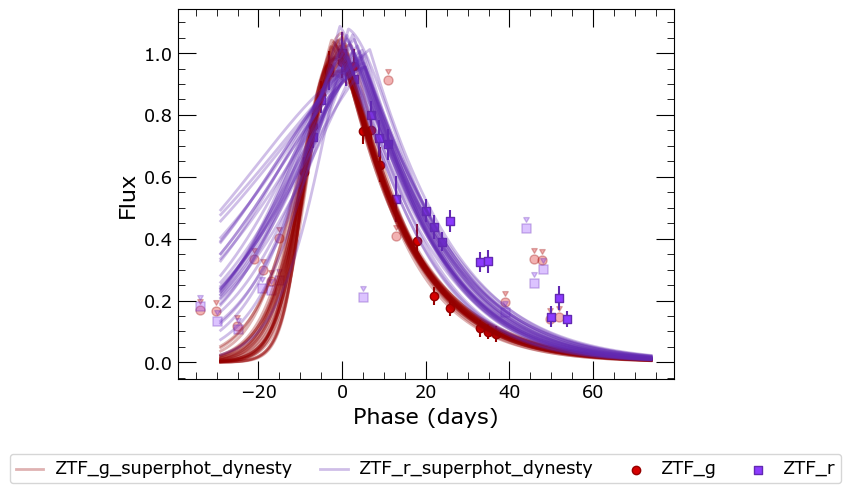

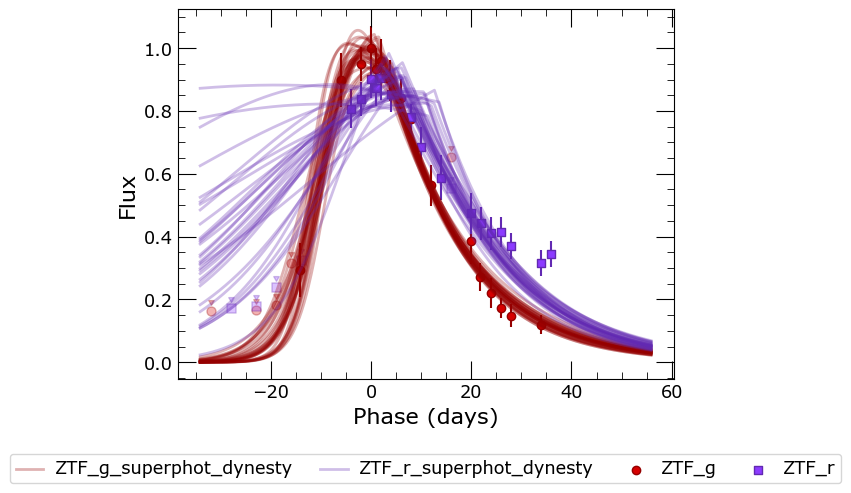

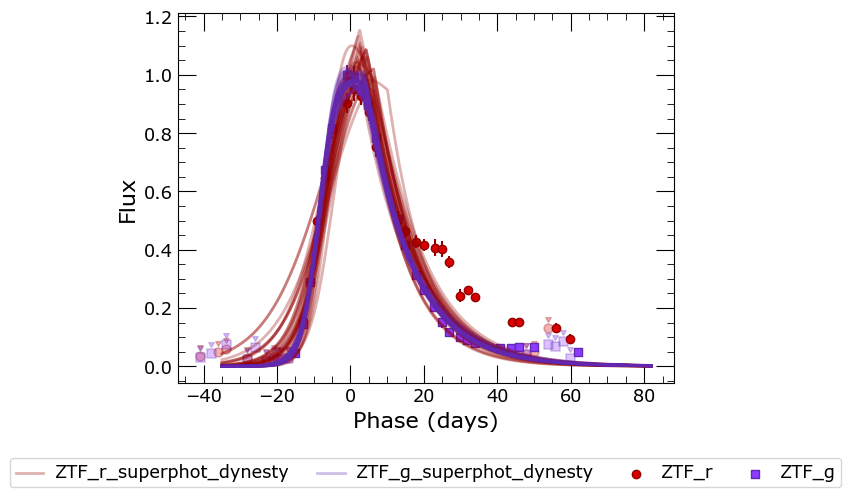

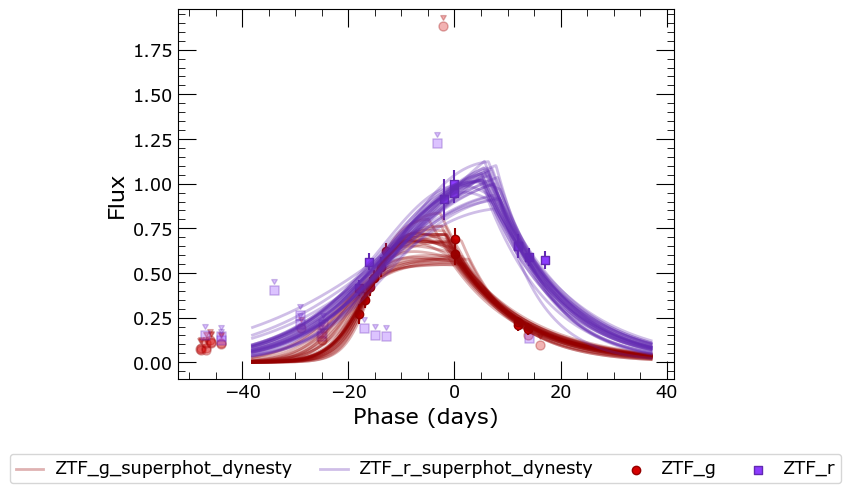

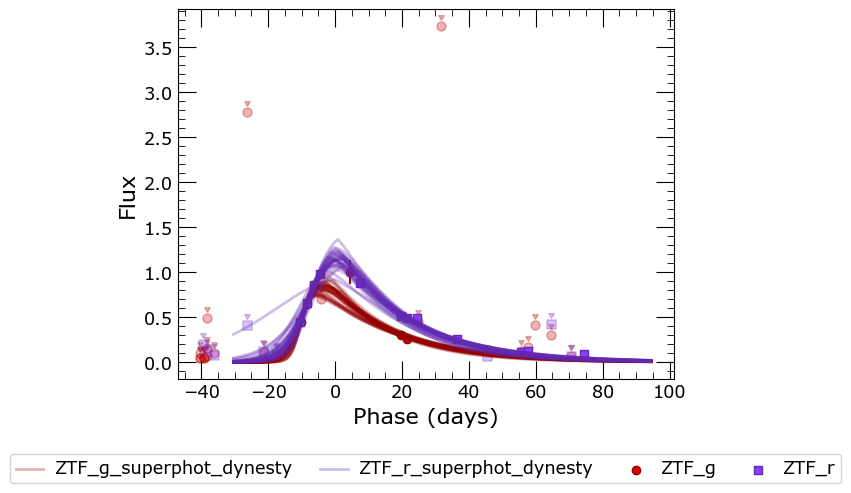

In [ ]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

names = sampler_results.metadata.index

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    formatter.reset_colors()
    formatter.reset_markers()
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)

    formatter.reset_colors()
    formatter.reset_markers()
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [2]:
# warning: only run once!
import os
from snapi import SamplerResultGroup, TransientGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(
    os.path.join(
        config.data_dir,
        "tmp_sampler_results"
    )
)

# also add peak_abs_mag column
transient_group = TransientGroup.load(config.transient_data_fn)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    n = sr.id
    transient = transient_group[n]    
    params = priors.reverse_transform(sr.fit_parameters)
    params['peak_abs_mag'] = transient.peak_abs_mag
    sr.fit_parameters = params
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)

print(new_sampler_results.metadata)


Converted 0 out of 7420 fits
Converted 1000 out of 7420 fits
Converted 2000 out of 7420 fits
Converted 3000 out of 7420 fits
Converted 4000 out of 7420 fits
Converted 5000 out of 7420 fits
Converted 6000 out of 7420 fits
Converted 7000 out of 7420 fits
          A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                                
2019J          -0.035846           0.005387            1.334764   
2019aafe       -0.047570           0.006027            0.961185   
2019aamp       -0.023522           0.005510            1.352493   
2019aanx        0.016946           0.004141            1.545718   
2019aaot        0.067832           0.003557            1.790828   
...                  ...                ...                 ...   
2025tt          0.008560           0.004430            1.218840   
2025ud         -0.018024           0.004816            1.353630   
2025wl         -0.010590           0.004773            1.313432   
2025xj    

In [3]:
# make summary df and all samples
import os
from snapi import SamplerResultGroup, TransientGroup
from superphot_plus.config import SuperphotConfig
import pandas as pd

config = SuperphotConfig.from_file("config.yaml")
srg = SamplerResultGroup.load(config.sampler_results_fn)
metadata = srg.metadata
metadata.to_csv(config.data_dir + "all_samples.csv")

# summary df
tg = TransientGroup.load(config.transient_data_fn)
tg.add_col("max_phase", lambda x: x.photometry.detections.index.days.max())
metadata = tg.metadata
metadata2 = srg.metadata
merged_meta = pd.merge(metadata, metadata2, how='outer', left_index=True, right_index=True)
merged_meta['use_early_classifier'] = (10**merged_meta['gamma_ZTF_r_median'] + merged_meta['t_0_ZTF_r_median']) > merged_meta['max_phase']
merged_meta.to_csv(os.path.join(config.data_dir, "summary.csv"))
print('metadata saved')

metadata saved


## Step 3: Train + evaluate classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [1]:
from superphot_plus import SuperphotConfig, SuperphotTrainer

config = SuperphotConfig.from_file("config.yaml")
trainer = SuperphotTrainer(config)
trainer.config.input_features = [
    #"A_ZTF_r",
    #"peak_abs_mag",
    "beta_ZTF_r",
    "gamma_ZTF_r",
    "tau_rise_ZTF_r",
    "tau_fall_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "gamma_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "tau_fall_ZTF_g",
    "extra_sigma_ZTF_g",
]
trainer.run()

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(
/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/s

Finally, we train a version of the classifier without a test set (aka we use the entire dataset in training or validation). This is what we'll be using to classify a new, disparate dataset.

In [1]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
from snapi import TransientGroup, SamplerResultGroup

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)
train_df, val_df = trainer.split(meta_df, split_frac=0.1)

train_srg = srg.filter(train_df.index)
val_srg = srg.filter(val_df.index)


# train full-type
trainer.config.input_features = [
    "beta_ZTF_r",
    "gamma_ZTF_r",
    "tau_rise_ZTF_r",
    "tau_fall_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "gamma_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "tau_fall_ZTF_g",
    "extra_sigma_ZTF_g",
]
trainer.train(0, (train_df, train_srg), (val_df, val_srg))
trainer.models[0].save(config.model_prefix + "_full")
probs_avg = trainer.evaluate(0, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_full.csv")


# train early-type
trainer.config.input_features = [
    "beta_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]
trainer.train(1, (train_df, train_srg), (val_df, val_srg))
trainer.models[1].save(config.model_prefix + "_early")
probs_avg_early = trainer.evaluate(1, (meta_df, srg))
probs_avg_early.to_csv(config.probs_fn[:-4] + "_early.csv")

# train redshift-inclusive full
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "gamma_ZTF_r",
    "tau_rise_ZTF_r",
    "tau_fall_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "gamma_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "tau_fall_ZTF_g",
    "extra_sigma_ZTF_g",
    "peak_abs_mag",
]
trainer.train(2, (train_df, train_srg), (val_df, val_srg))
trainer.models[2].save(config.model_prefix + "_redshift")
probs_avg = trainer.evaluate(2, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_full_redshift.csv")

# train redshift-inclusive early
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
    "peak_abs_mag",
]
trainer.train(3, (train_df, train_srg), (val_df, val_srg))
trainer.models[3].save(config.model_prefix + "_early_redshift")
probs_avg = trainer.evaluate(3, (meta_df, srg))
probs_avg.to_csv(config.probs_fn[:-4] + "_early_redshift.csv")

/Users/kdesoto/conda_envs/superphot_env/lib/python3.11/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (5.2.0)/charset_normalizer (3.4.0) doesn't match a supported version!
  warnings.warn(


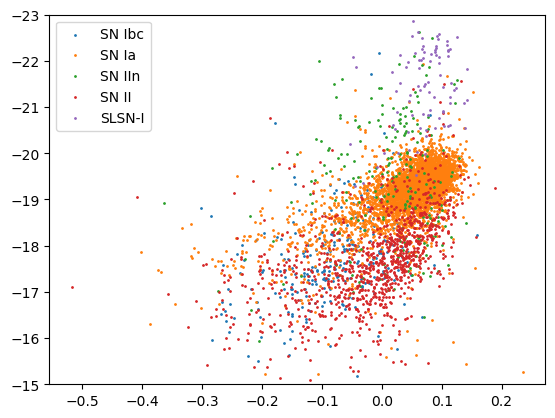

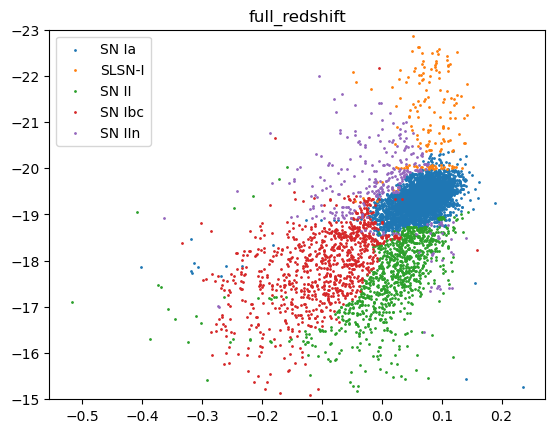

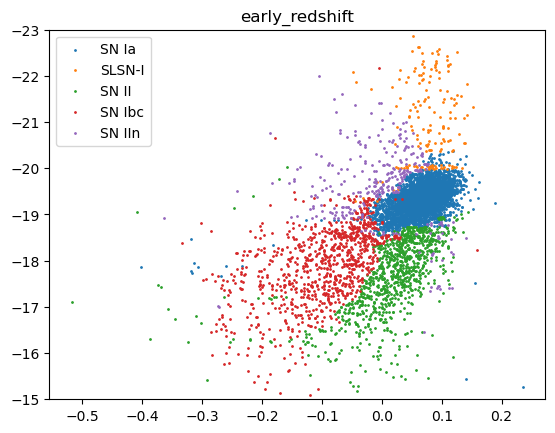

In [3]:
from superphot_plus import SuperphotConfig, SuperphotTrainer
from snapi import TransientGroup, SamplerResultGroup
import matplotlib.pyplot as plt
import pandas as pd

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
srg = SamplerResultGroup.load(config.sampler_results_fn)

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group)
train_df, val_df = trainer.split(meta_df, split_frac=0.1)
train_srg = srg.filter(train_df.index)
val_srg = srg.filter(val_df.index)

feature_df = train_srg.metadata

for c in train_df['canonical_class'].unique():
    plt.scatter(
        feature_df.loc[train_df['canonical_class'] == c, 'A_ZTF_g_median'],
        feature_df.loc[train_df['canonical_class'] == c, 'peak_abs_mag_median'],
        s=1, label=c
    )
plt.ylim((-15, -23))
plt.legend()
plt.show()

# check classifier predictions (are they reasonable?)
for extension in ["full_redshift", "early_redshift", ]: #"full", "early", ]:
    pred_df = pd.read_csv(config.probs_fn[:-4] + f"_{extension}.csv", index_col=0)

    for c in pred_df['pred_class'].unique():
        pred_names = pred_df.loc[pred_df.pred_class == c].index
        orig_df = feature_df.loc[feature_df.index.isin(pred_names)]
        plt.scatter(
            orig_df['A_ZTF_g_median'],
            orig_df['peak_abs_mag_median'],
            s=1, label=c
        )
    plt.ylim((-15, -23))
    plt.title(extension)
    plt.legend()
    plt.show()

{'objname': 'ZTF25aakoamh', 'internal_names': {'2025fto', 'ANT2025jlqfe43gi2yl'}, 'coordinates': <SkyCoord (ICRS): (ra, dec) in deg
    (234.9197822, 6.34187623)>, 'redshift': None, 'spec_class': '', 'light_curves': [<snapi.photometry.lightcurve.LightCurve object at 0x397dde790>, <snapi.photometry.lightcurve.LightCurve object at 0x161715b10>], 'spectra': set()}
{'objname': '', 'internal_names': set(), 'coordinates': None, 'redshift': None, 'spec_class': None, 'light_curves': [], 'spectra': set()}
{'objname': '', 'internal_names': set(), 'coordinates': None, 'redshift': None, 'spec_class': None, 'light_curves': [], 'spectra': set()}
{'objname': '', 'internal_names': set(), 'coordinates': None, 'redshift': None, 'spec_class': None, 'light_curves': [], 'spectra': set()}
{'objname': '', 'internal_names': set(), 'coordinates': None, 'redshift': None, 'spec_class': None, 'light_curves': [], 'spectra': set()}
-19.2


/Users/kdesoto/python_repos/snapi/src/snapi/photometry/photometry.py:173: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  lambda x: (x["mag"] + x["mag_error"]).idxmin()


{'loc_base': Array([-0.04665482,  0.00484297,  1.3398514 , -1.7221375 ,  0.42729473,
        1.3889353 , -1.3125601 ], dtype=float32), 'loc_relative': Array([ 0.03612351,  0.00936155,  1.2287393 , -1.2995148 ,  0.48750484,
        1.1740006 , -1.6336968 ], dtype=float32), 'scale_base': Array([0.02566343, 0.00131611, 0.12963341, 0.89390063, 0.13969408,
       0.12805447, 0.1670804 ], dtype=float32), 'scale_relative': Array([0.02460794, 0.00166202, 0.12870413, 0.47421026, 0.08332925,
       0.1476682 , 0.23377277], dtype=float32)}
      A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
0    0.928086    0.004446    20.958265  -2.681242        1.634155   
1    0.871040    0.005694    28.873680  -1.714206        1.511862   
2    0.818871    0.007246    22.110123  -1.931014        3.077501   
3    0.896657    0.002524    15.985024  -2.504371        1.741676   
4    0.913636    0.004669    24.963625   0.574271        3.529053   
..        ...         ...          ...        ...  

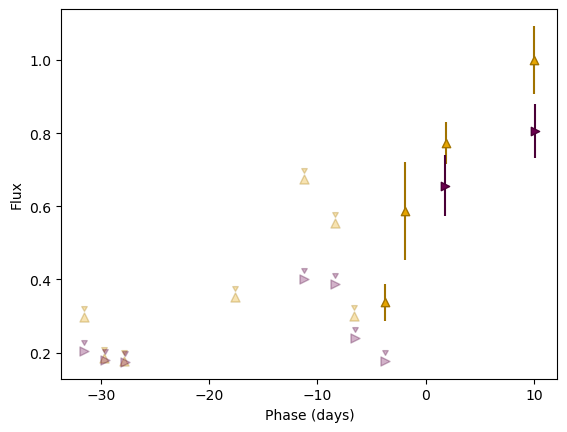

          A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
2025fto -0.032412    0.004446     1.321355  -2.681242        0.213293   
2025fto -0.059962    0.005694     1.460502  -1.714206        0.179512   
2025fto -0.086785    0.007246     1.344591  -1.931014        0.488198   
2025fto -0.047373    0.002524     1.203713  -2.504371        0.240967   
2025fto -0.039227    0.004669     1.397308   0.574271        0.547658   
...           ...         ...          ...        ...             ...   
2025fto -0.085402    0.004480     1.453249  -2.918354        0.491628   
2025fto -0.046027    0.005780     1.491227  -2.036766        0.423591   
2025fto -0.067272    0.005032     1.285659  -2.157044        0.313372   
2025fto -0.020837    0.004558     1.503841  -2.758046        0.542676   
2025fto -0.082625    0.006644     1.361604  -0.655336        0.327982   

         tau_fall_ZTF_r  extra_sigma_ZTF_r   A_ZTF_g  beta_ZTF_g  gamma_ZTF_g  \
2025fto        1.411315          -1.135974

In [ ]:
# Classify specific object (for debugging of Slackbot)
from snapi.query_agents import ALeRCEQueryAgent, TNSQueryAgent, ANTARESQueryAgent
from snapi import Transient, TransientGroup, SamplerResultGroup, Photometry, Formatter
from superphot_plus import SuperphotConfig, SuperphotTrainer, SuperphotLightGBM
from superphot_plus.priors import SuperphotPrior
from superphot_plus.samplers import SVISampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

test_sn = "2025fto"
redshift = 0.07936
peak_abs_mag = -19.2

formatter = Formatter()
config = SuperphotConfig.from_file("config.yaml")
priors = SuperphotPrior.load('priors/global_priors_hier_svi')
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

models = {
    "full": SuperphotLightGBM.load(config.model_prefix + "_full.pt"),
    "early": SuperphotLightGBM.load(config.model_prefix + "_early.pt"),
    "full_redshift": SuperphotLightGBM.load(config.model_prefix + "_redshift.pt"),
    "early_redshift": SuperphotLightGBM.load(config.model_prefix + "_early_redshift.pt")
}

tns_agent = TNSQueryAgent()
antares_agent = ANTARESQueryAgent()

transient = Transient(iid=test_sn)
qr_tns, _ = tns_agent.query_transient(transient, local=False) # we dont want spectra
for result in qr_tns:
    transient.ingest_query_info(result.to_dict())

qr_alerce, _ = antares_agent.query_transient(transient)
for result in qr_alerce:
    print(result.to_dict())
    transient.ingest_query_info(result.to_dict())

phot = transient.photometry
        
new_lcs = []
for lc in phot.light_curves:
    lc.merge_close_times(inplace=True)
    new_lcs.append(lc)
        
phot = Photometry.from_light_curves(new_lcs)
phot.phase(inplace=True)
        
# adjust for time dilation
if ~np.isnan(redshift):
    phot.times /= (1. + redshift)
            
phot.truncate(min_t=-50., max_t=100.)
        
phot.correct_extinction(
    coordinates=transient.coordinates,
    inplace=True
)
phot_abs = phot.absolute(redshift)
# #phot_abs.detections.mag.dropna().min()
print(peak_abs_mag)
phot.normalize(inplace=True)

# create padded photometry for use in SVI
padded_lcs = []
orig_size = len(phot.detections)
num_pad = int(2**np.ceil(np.log2(orig_size)))

fill = {'phase': 1000., 'flux': 0.1, 'flux_error': 1000., 'zeropoint': 23.90, 'upper_limit': False}
for lc in phot.light_curves:
    padded_lc=lc.pad(fill, num_pad - len(lc.detections))
    padded_lcs.append(padded_lc)

padded_phot = Photometry.from_light_curves(padded_lcs)

# fit with SVI and extract result
svi_sampler.reset() # reinitialize for future SVI fits
svi_sampler.fit_photometry(padded_phot, orig_num_times=orig_size)

fig, ax = plt.subplots()
#svi_sampler.plot_fit(ax=ax, formatter=formatter, photometry=phot)
phot.plot(ax=ax, formatter=formatter, mags=False)
plt.show()

results = svi_sampler.result
color = results.fit_parameters.A_ZTF_g.median()

# convert fit parameters back to uncorrelated Gaussian draws
uncorr_fits = priors.reverse_transform(results.fit_parameters)
uncorr_fits.index = [test_sn,] * len(uncorr_fits)

# add magnitude to uncorr_fits
uncorr_fits['peak_abs_mag'] = peak_abs_mag
print(uncorr_fits)

allowed_types = ['SLSN-I', 'SN Ia', 'SN Ibc', 'SN II', 'SN IIn']
for model_type in ['full', 'early', 'full_redshift', 'early_redshift']:
    model = models[model_type]
    print(model.best_model.feature_names_in_)
    """
    probs_avg = model.evaluate(
        uncorr_fits[input_features[model_type]]
    )
    """
    input_features = model.best_model.feature_names_in_
    test_features = model.normalize(uncorr_fits[input_features])
    probabilities = pd.DataFrame(
        model.best_model.predict_proba(test_features),
        index=test_features.index
    )
    probabilities.columns = np.sort(allowed_types)
    best_classes = probabilities.idxmax(axis=1)
    print(model_type)
    probs = best_classes.value_counts() / best_classes.count()
        
    print(ia_idx)

    #
    #sp_class = probs_avg.idxmax(axis=1).iloc[0]
    #sp_prob = np.round(probs_avg.max(axis=1).iloc[0], 3)
    #Ia_prob = np.round(probs_avg['SN Ia'].iloc[0], 3)

    #print(model_type, sp_class, sp_prob, Ia_prob)






# Optional: Generate and classify photometric dataset

Here, we generate a photometric dataset based on fairly generous cuts, and classify using our trained models. These are objects that do not have spectroscopic classifications.

## Step 1: Generate initial dataset.

In [1]:
from snapi.query_agents import TNSQueryAgent
tns_agent = TNSQueryAgent()
#tns_agent.update_local_database() # IMPORTANT: run this line if first time using SNAPI or if you want to reimport TNS csv
all_names = tns_agent.retrieve_all_names(known_class = False) # ALL TNS OBJECTS (some without labels)
all_names = [x for x in all_names if int(x[:4]) > 2018] # because pre-2019 templates are pretty bad
print(len(all_names), all_names[:5])

133060 ['2025caw', '2025cav', '2025cau', '2025cat', '2025bsl']


In [2]:
# apply data quality cuts, and filter by lack of spectroscopic classifications

import os
from superphot_plus.data_generation import import_all_phot_names

save_dir = "/Users/kdesoto/superphot-plus-data/transients_phot_group"
os.makedirs(save_dir, exist_ok=True)
# import data for all_names from query agents
import_all_phot_names(
    all_names, save_dir,
    checkpoint_freq=4096,
    n_cores=8,
    max_n = 200_000,
    overwrite=False
) # set overwrite=False to continue from where left off

2218 events already saved.
130842 names to query across 8 cores.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 2339.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 2454.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 2571.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 2707.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 2848.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3004.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3126.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3282.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3429.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3579.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3725.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 3856.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4007.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4137.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4277.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4400.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4536.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4683.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4824.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 4965.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 5100.
Processing 4221 transients in batch


Finished processing, making transient group now
Total transients saved: 5242.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 5376.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 5522.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 5645.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 5774.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 5907.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 6033.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 6159.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 6295.
Processing 4220 transients in batch


Finished processing, making transient group now
Total transients saved: 6425.


## Step 2: Fit with global priors

In [3]:
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import SuperphotPrior
from superphot_plus.config import SuperphotConfig
import os

config = SuperphotConfig.from_file("config.yaml")
priors = SuperphotPrior.load('priors/global_priors_hier_svi')

svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load("/Users/kdesoto/superphot-plus-data/transients_phot_group")
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = "/Users/kdesoto/superphot-plus-data/srg_phot",
    checkpoint_freq = 512,
    pad=True,
    overwrite=False # set to False to continue where left off
)
SamplerResultGroup(result).save("/Users/kdesoto/superphot-plus-data/srg_phot")

2025-02-25 07:54:48,944 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:54:48,947 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-25 07:54:48,948 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1740488088.948751 13206593 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740488088.995218 13206593 service.cc:145] XLA service

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

['A_ZTF_r' 'beta_ZTF_r' 'gamma_ZTF_r' 't_0_ZTF_r' 'tau_rise_ZTF_r'
 'tau_fall_ZTF_r' 'extra_sigma_ZTF_r' 'A_ZTF_g' 'beta_ZTF_g' 'gamma_ZTF_g'
 't_0_ZTF_g' 'tau_rise_ZTF_g' 'tau_fall_ZTF_g' 'extra_sigma_ZTF_g'] ['A', 'beta', 'gamma', 't_0', 'tau_rise', 'tau_fall', 'extra_sigma']
Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 07:55:30,911 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:55:30,913 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:55:30,913 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 ProMetal device set to: Metal device set to: 
systemMemory: 16.00 GB
Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: 
Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Apple M1 Pro
Metal device set to: 
systemMemory: 16.00 GB
Apple M1 Pro
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 07:56:22,657 - MainProcess - Worker done
2025-02-25 07:56:23,071 - MainProcess - Worker done
2025-02-25 07:56:23,972 - MainProcess - Worker done
2025-02-25 07:56:25,569 - MainProcess - Worker done
2025-02-25 07:56:26,797 - MainProcess - Worker done
2025-02-25 07:56:27,555 - MainProcess - Worker done
2025-02-25 07:56:28,331 - MainProcess - Worker done
2025-02-25 07:56:30,002 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0


Finished checkpoint 1 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 07:56:43,268 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:56:43,269 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:56:43,270 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 07:57:35,352 - MainProcess - Worker done
2025-02-25 07:57:36,572 - MainProcess - Worker done
2025-02-25 07:57:37,000 - MainProcess - Worker done
2025-02-25 07:57:37,477 - MainProcess - Worker done
2025-02-25 07:57:37,702 - MainProcess - Worker done
2025-02-25 07:57:38,772 - MainProcess - Worker done
2025-02-25 07:57:39,265 - MainProcess - Worker done
2025-02-25 07:57:40,346 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 2 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 07:57:54,689 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:57:54,691 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such fi

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Metal device set to: Apple M1 ProApple M1 Pro


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 07:58:47,575 - MainProcess - Worker done
2025-02-25 07:58:47,908 - MainProcess - Worker done
2025-02-25 07:58:48,797 - MainProcess - Worker done
2025-02-25 07:58:49,069 - MainProcess - Worker done
2025-02-25 07:58:49,069 - MainProcess - Worker done
2025-02-25 07:58:49,525 - MainProcess - Worker done
2025-02-25 07:58:49,713 - MainProcess - Worker done
2025-02-25 07:58:49,911 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0


Finished checkpoint 3 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 07:59:05,785 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:59:05,787 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 07:59:05,789 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 07:59:57,642 - MainProcess - Worker done
2025-02-25 07:59:57,722 - MainProcess - Worker done
2025-02-25 07:59:57,951 - MainProcess - Worker done
2025-02-25 07:59:58,241 - MainProcess - Worker done
2025-02-25 07:59:58,956 - MainProcess - Worker done
2025-02-25 07:59:59,875 - MainProcess - Worker done
2025-02-25 08:00:00,065 - MainProcess - Worker done
2025-02-25 08:00:01,663 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down


Finished checkpoint 4 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:00:18,442 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:00:18,446 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such fi

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:01:09,738 - MainProcess - Worker done
2025-02-25 08:01:09,812 - MainProcess - Worker done
2025-02-25 08:01:11,908 - MainProcess - Worker done
2025-02-25 08:01:12,071 - MainProcess - Worker done
2025-02-25 08:01:12,696 - MainProcess - Worker done
2025-02-25 08:01:14,048 - MainProcess - Worker done
2025-02-25 08:01:14,839 - MainProcess - Worker done
2025-02-25 08:01:16,134 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with ex

Finished checkpoint 5 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:01:35,090 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:01:35,092 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:01:35,097 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



I0000 00:00:1740488495.304076 13823551 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740488495.304097 13823551 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.
2025-02-25 08:01:35,374 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:01:35,380 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
2025-02-25 08:01:35,380 - MainProcess - Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 0

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:02:25,009 - MainProcess - Worker done
2025-02-25 08:02:25,543 - MainProcess - Worker done
2025-02-25 08:02:28,086 - MainProcess - Worker done
2025-02-25 08:02:28,132 - MainProcess - Worker done
2025-02-25 08:02:28,279 - MainProcess - Worker done
2025-02-25 08:02:29,573 - MainProcess - Worker done
2025-02-25 08:02:30,304 - MainProcess - Worker done
2025-02-25 08:02:31,180 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with ex

Finished checkpoint 6 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:02:51,620 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:02:51,620 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:02:51,623 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:03:41,431 - MainProcess - Worker done
2025-02-25 08:03:41,605 - MainProcess - Worker done
2025-02-25 08:03:42,914 - MainProcess - Worker done
2025-02-25 08:03:44,109 - MainProcess - Worker done
2025-02-25 08:03:44,799 - MainProcess - Worker done
2025-02-25 08:03:44,866 - MainProcess - Worker done
2025-02-25 08:03:45,239 - MainProcess - Worker done
2025-02-25 08:03:47,512 - MainProcess - Worker done
[INFO/MainProcess] process shutting down


Finished checkpoint 7 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:04:09,163 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:04:09,165 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such fi

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:05:00,924 - MainProcess - Worker done
2025-02-25 08:05:01,483 - MainProcess - Worker done
2025-02-25 08:05:01,663 - MainProcess - Worker done
2025-02-25 08:05:02,390 - MainProcess - Worker done
2025-02-25 08:05:02,607 - MainProcess - Worker done
2025-02-25 08:05:02,748 - MainProcess - Worker done
2025-02-25 08:05:02,980 - MainProcess - Worker done
2025-02-25 08:05:03,064 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[

Finished checkpoint 8 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:05:26,536 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:05:26,539 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:05:26,540 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:06:16,500 - MainProcess - Worker done
2025-02-25 08:06:19,506 - MainProcess - Worker done
2025-02-25 08:06:19,636 - MainProcess - Worker done
2025-02-25 08:06:20,098 - MainProcess - Worker done
2025-02-25 08:06:20,288 - MainProcess - Worker done
2025-02-25 08:06:21,053 - MainProcess - Worker done
2025-02-25 08:06:21,236 - MainProcess - Worker done
2025-02-25 08:06:21,403 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 9 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:06:48,937 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:06:48,938 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:06:48,939 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB


systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:07:49,053 - MainProcess - Worker done
2025-02-25 08:07:50,179 - MainProcess - Worker done
2025-02-25 08:07:50,214 - MainProcess - Worker done
2025-02-25 08:07:50,653 - MainProcess - Worker done
2025-02-25 08:07:51,510 - MainProcess - Worker done
2025-02-25 08:07:52,143 - MainProcess - Worker done
2025-02-25 08:07:53,312 - MainProcess - Worker done
2025-02-25 08:07:54,047 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0


Finished checkpoint 10 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:08:21,244 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:08:21,246 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such fi

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:09:10,219 - MainProcess - Worker done
2025-02-25 08:09:11,265 - MainProcess - Worker done
2025-02-25 08:09:13,424 - MainProcess - Worker done
2025-02-25 08:09:13,954 - MainProcess - Worker done
2025-02-25 08:09:14,267 - MainProcess - Worker done
2025-02-25 08:09:14,503 - MainProcess - Worker done
2025-02-25 08:09:14,686 - MainProcess - Worker done
2025-02-25 08:09:14,849 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down


Finished checkpoint 11 of 12


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
2025-02-25 08:09:44,375 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:09:44,380 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-02-25 08:09:44,380 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/kdesoto/conda_envs/superphot_env/bin/../lib/libt

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2025-02-25 08:10:36,692 - MainProcess - Worker done
2025-02-25 08:10:37,374 - MainProcess - Worker done
2025-02-25 08:10:38,200 - MainProcess - Worker done
2025-02-25 08:10:38,354 - MainProcess - Worker done
2025-02-25 08:10:41,155 - MainProcess - Worker done
2025-02-25 08:10:41,327 - MainProcess - Worker done
2025-02-25 08:10:41,484 - MainProcess - Worker done
2025-02-25 08:10:43,665 - MainProcess - Worker done
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process shutting down
[INFO/MainProcess] process exiting with exitcode 0
[

Finished checkpoint 12 of 12


## Step 3: Adjust fit parameters and pass to classifiers

In [4]:
# Adjust parameters
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load("/Users/kdesoto/superphot-plus-data/srg_phot")

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    sr.fit_parameters = priors.reverse_transform(sr.fit_parameters)
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save("/Users/kdesoto/superphot-plus-data/srg_phot_gauss")

Converted 0 out of 6425 fits
Converted 1000 out of 6425 fits
Converted 2000 out of 6425 fits
Converted 3000 out of 6425 fits
Converted 4000 out of 6425 fits
Converted 5000 out of 6425 fits
Converted 6000 out of 6425 fits


In [5]:
# add extra column to transientgroup
tg = TransientGroup.load("/Users/kdesoto/superphot-plus-data/transients_phot_group")
tg.add_col("max_phase", lambda x: x.photometry.detections.index.days.max())
tg.save("/Users/kdesoto/superphot-plus-data/transients_phot_group")

In [1]:
# Pass to both classifiers
from superphot_plus import SuperphotConfig, SuperphotTrainer, SuperphotLightGBM
from snapi import TransientGroup, SamplerResultGroup
import pandas as pd
from superphot_plus.supernova_class import SupernovaClass as SnClass


config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load('/Users/kdesoto/superphot-plus-data/transients_phot_group')
srg = SamplerResultGroup.load('/Users/kdesoto/superphot-plus-data/srg_phot_gauss')

metadata = transient_group.metadata
metadata2 = srg.metadata
merged_meta = pd.merge(transient_group.metadata, srg.metadata, how='outer', left_index=True, right_index=True)
merged_meta['use_early_classifier'] = (10**merged_meta['gamma_ZTF_r_median'] + merged_meta['t_0_ZTF_r_median']) > merged_meta['max_phase']
merged_meta.to_csv("/Users/kdesoto/superphot-plus-data/summary_custom.csv")
print('metadata saved')

trainer = SuperphotTrainer(config)
trainer.setup_model()
meta_df = trainer.retrieve_transient_metadata(transient_group, keep_original_labels=True)

trainer.models[0] = SuperphotLightGBM.load(config.model_prefix + "_full.pt")
trainer.models[1]= SuperphotLightGBM.load(config.model_prefix + "_early.pt")
probs_avg = trainer.evaluate(0, (meta_df, srg))
probs_avg[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']] = probs_avg[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']].round(2)
probs_avg['max_prob'] = probs_avg[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']].max(axis=1)
probs_avg.drop(columns=['true_class','fold'], inplace=True)
probs_avg.to_csv("/Users/kdesoto/superphot-plus-data/probs_phot_full.csv")

print("Full results saved")
# train early-type
trainer.config.input_features = [
    "A_ZTF_r",
    "beta_ZTF_r",
    "t_0_ZTF_r",
    "tau_rise_ZTF_r",
    "extra_sigma_ZTF_r",
    "A_ZTF_g",
    "beta_ZTF_g",
    "t_0_ZTF_g",
    "tau_rise_ZTF_g",
    "extra_sigma_ZTF_g",
]

probs_avg_early = trainer.evaluate(1, (meta_df, srg))
probs_avg_early[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']] = probs_avg_early[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']].round(2)
probs_avg_early['max_prob'] = probs_avg_early[['SLSN-I', 'SN II', 'SN Ia', 'SN Ibc', 'SN IIn']].max(axis=1)
probs_avg_early.drop(columns=['true_class','fold'], inplace=True)
probs_avg_early.to_csv("/Users/kdesoto/superphot-plus-data/probs_phot_early.csv")
print("Early results saved")


metadata saved
A
DONE
           A_ZTF_r  beta_ZTF_r  gamma_ZTF_r  t_0_ZTF_r  tau_rise_ZTF_r  \
id                                                                       
2019aabm -0.027516   -0.001440     1.422255 -17.062616        0.375353   
2019aabm -0.064075   -0.000953     1.435461 -16.444597        0.540520   
2019aabm -0.037576   -0.001774     1.355396 -16.916914        0.391980   
2019aabm -0.048594   -0.001221     1.428783 -17.786188        0.406899   
2019aabm -0.055528   -0.001049     1.529043 -15.934857        0.611801   
...            ...         ...          ...        ...             ...   
2025ui   -0.028959   -0.001386     1.120139  -6.245208        0.402134   
2025ui   -0.009931   -0.001159     1.130017  -5.793097        0.377766   
2025ui   -0.020198   -0.001289     1.076548  -5.854780        0.338291   
2025ui    0.002241   -0.001372     1.133298  -6.162996        0.420417   
2025ui   -0.027617   -0.001008     1.096302  -5.084650        0.343523   

          tau_f